# BIGRAM Language Modelling
Here, I'll implement a simple bigram model to predict the next character in a sequence.

In [1]:
# Load the dataset
with open('names.txt', 'r') as f:
    names = f.read().splitlines()

print(f"Count: {len(names)}, sample: {names[:5]}...")

Count: 32033, sample: ['emma', 'olivia', 'ava', 'isabella', 'sophia']...


## Creating a bigram model

To create a very basic bi-gram model, we'll split our dataset into pairs of 2.

We'll have to encode 'beginning' and 'end' special chars (e.g. '>' and '.').

Then, we want to count the frequencies of these chars from our dataset (i.e. we need a 2D matrix -> given the first character, what's the likely next char).

We'll want to also normalize the dataset per row (this gives us a nice 0-1 value which we can use for sampling the next char using a probability distribution (which type of distribution? Uniform random distribution?))

Count: 32033, sample: ['>emma.', '>olivia.', '>ava.', '>isabella.', '>sophia.']...


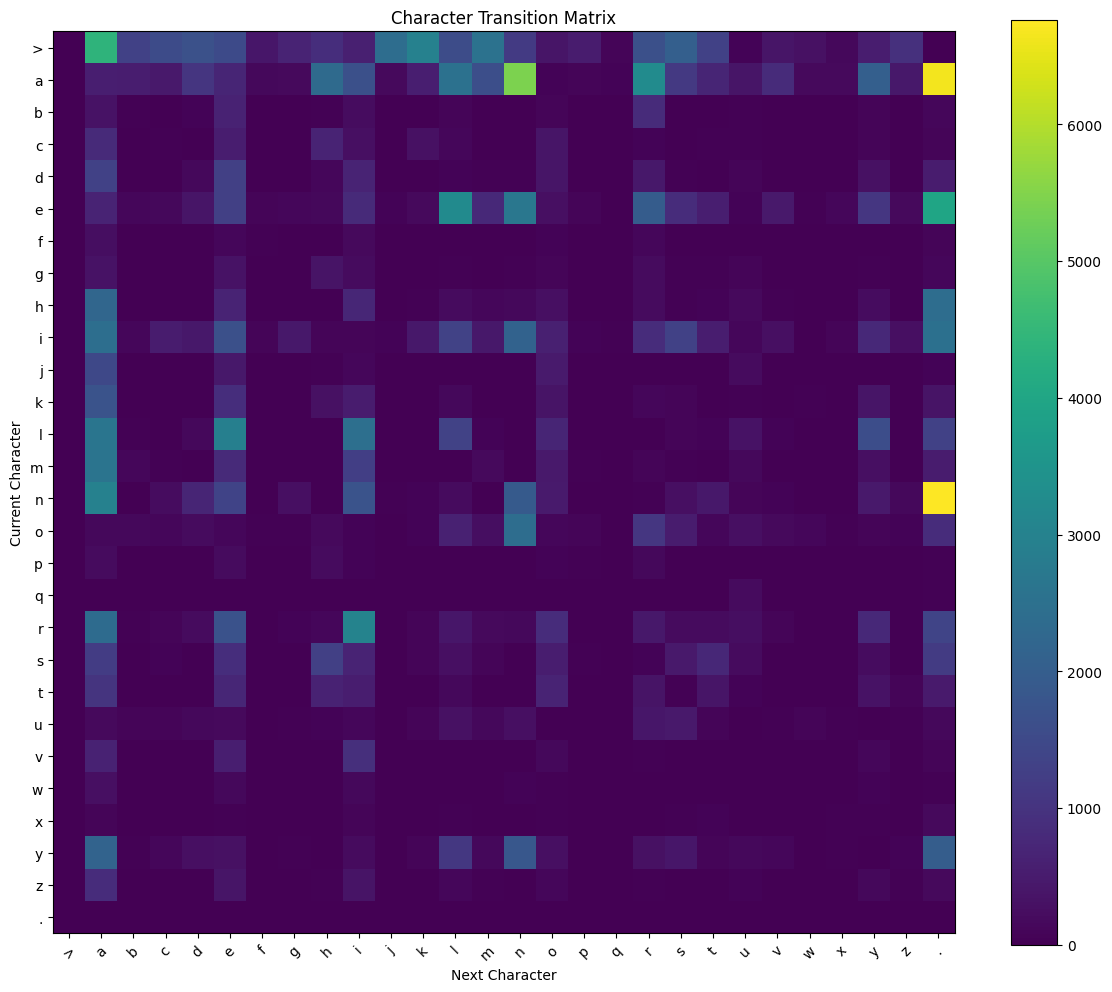

In [2]:
import torch
formatted_names = []

# Preprend + append the start/end tokens
START_TOKEN = ">"
END_TOKEN = "."

for name in names:
    formatted = START_TOKEN + name + END_TOKEN
    formatted_names.append(formatted)

print(f"Count: {len(formatted_names)}, sample: {formatted_names[:5]}...")

# Create a 2-char sliding window and count the frequencies
VOCAB_SIZE = 28
matrix = torch.zeros((VOCAB_SIZE,VOCAB_SIZE), dtype=torch.int32)

for formatted_name in formatted_names:
    for i, char in enumerate(formatted_name):
        if i == 0:
            continue
        
        first = formatted_name[i-1]
        second = formatted_name[i]

        first_i = ord(first)-ord('a')+1
        second_i = ord(second)-ord('a')+1
        
        if first == START_TOKEN:
            first_i = 0

        if second == END_TOKEN:
            second_i = 27

        matrix[first_i][second_i] += 1

#Print the matrix
import matplotlib.pyplot as plt
import numpy as np

def visualize_matrix(matrix_param):
    # Create labels for rows and columns
    labels = ['>'] + [chr(i+96) for i in range(1,27)] + ['.']

    plt.figure(figsize=(12,10))
    plt.imshow(matrix_param, cmap='viridis')
    plt.colorbar()

    # Set the ticks and labels
    plt.xticks(range(VOCAB_SIZE), labels, rotation=45)
    plt.yticks(range(VOCAB_SIZE), labels)

    plt.xlabel('Next Character')
    plt.ylabel('Current Character')
    plt.title('Character Transition Matrix')

    plt.tight_layout()
    plt.show()

visualize_matrix(matrix)

tensor(1.)

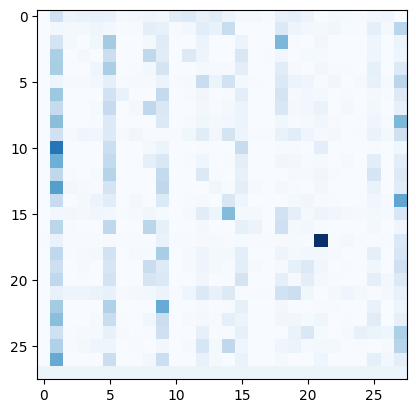

In [3]:
# Normalize each row
p = matrix.float()
p = p + 1
p = p / p.sum(1, keepdim=True)
plt.imshow(p, cmap="Blues")
p[27].sum()

In [4]:
g = torch.Generator().manual_seed(2147483647)

In [5]:
# Using the normalized matrix, we can now start to sample the dataset to predict the next token.
# Using the normalized matrix, we can now start to sample the dataset to predict the next token.
generated = ""
current_index = 0  # Start with '>' token (index 0)
latest_char = START_TOKEN

while latest_char != END_TOKEN:
    # Sample the next index based on the probability distribution in matrix[current_index]
    probs = p[current_index]
    next_index = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    
    # Convert index back to character
    if next_index == 0:
        latest_char = START_TOKEN
    elif next_index == 27:
        latest_char = END_TOKEN
    else:
        latest_char = chr(next_index + ord('a') - 1)
    
    if latest_char != END_TOKEN:  # Don't append the end token
        generated += latest_char
    
    current_index = next_index

print(f"Generated name: {generated}")

Generated name: junidedianasa
